input X_SAR before alignement: (3471, 19, 2)


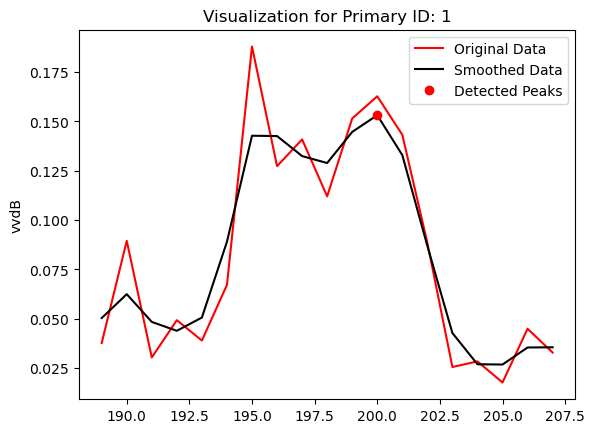

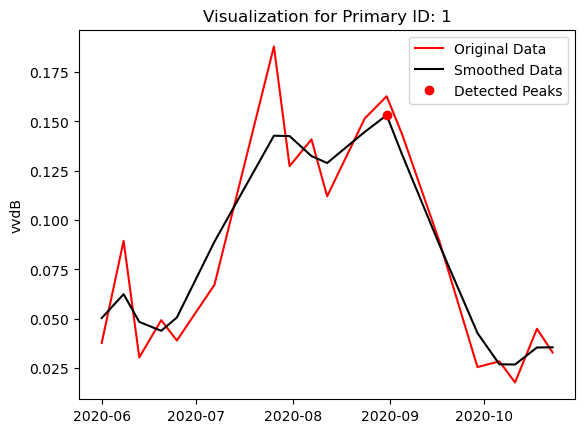

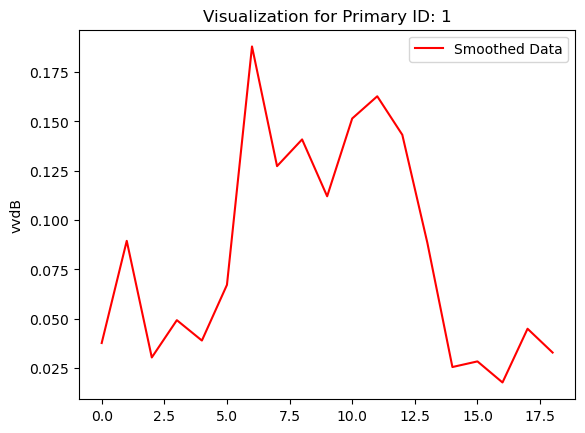

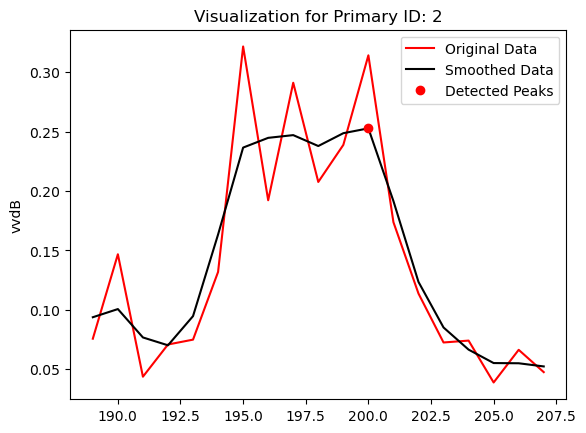

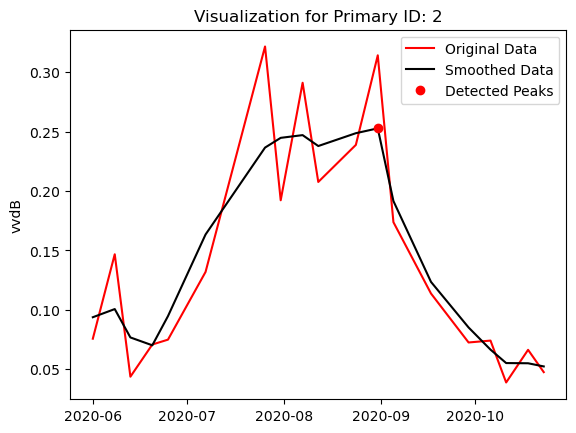

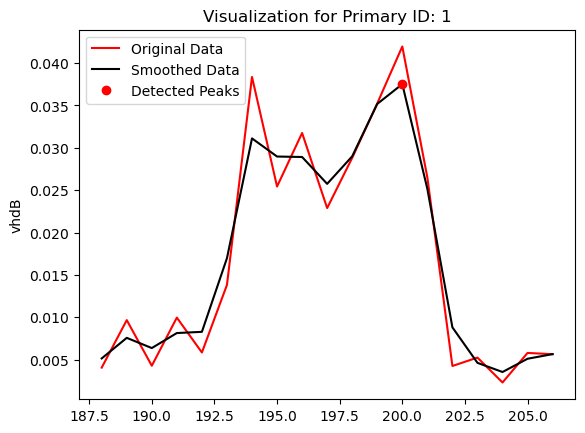

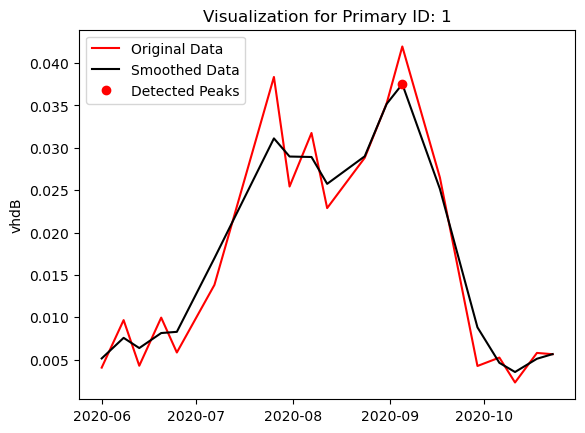

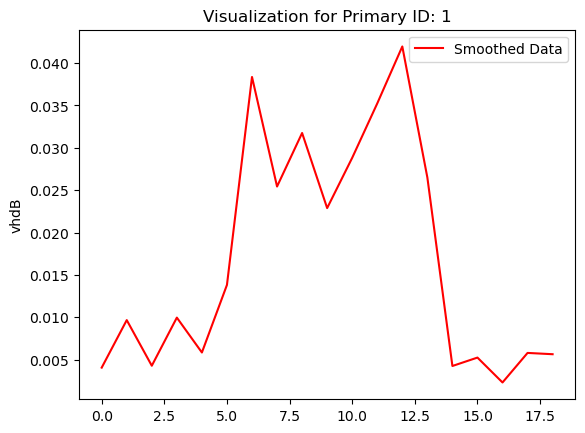

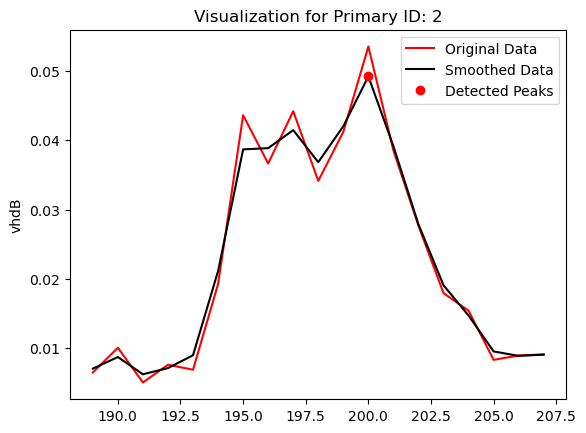

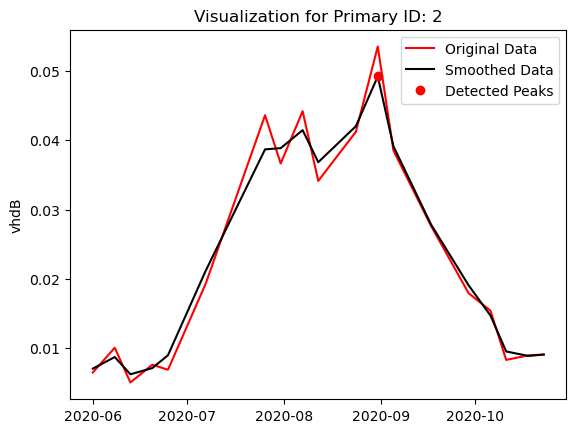

vv_smoothgauss_df_vv_final.shape (3471, 21)
vh_smoothgauss_df_vh_final.shape (3471, 21)


# Print the shape of the newly created X_SAR after removing primary_id and y from the vh_smoothgauss_df_vh_final and vv_smoothgauss_df_vv_final


Shape of X_SARn: (3471, 19, 2)
y (3471,)
id_parcels (3471,)
sar_dates (19, 1)
X_SARn (3471, 19, 2)


In [7]:

######### Created by Saeideh Maleki
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage

#######Part2. allignement using the Set_number value from the script Step2_Peak_Alignement and replace by Set_number value in current code
Set_number=10
def smooth_and_plot(df, pol_label, year,dates_SAR):
    peak_data = []
    doys_adjusted_list = []
    data_list = []
    valid_id_parcels = []
    valid_y_multi = []
    columns_added_list = []
    fig_count = 0

    for i in range(len(df)):
        data = df.iloc[i, :-2].values
        data = data.astype(float)
        data = np.nan_to_num(data)
        doys_arr = np.arange(len(data))

        nb = 4
        f = 0
        smoothed = []

        while nb > 3:
            f += 0.01
            data_smoothgauss = ndimage.filters.gaussian_filter(data, f)
            peak_pos, peak_amp = [], []
            bottom_pos, bottom_amp = [], []

            for k in range(1, len(data_smoothgauss) - 1):
                if data_smoothgauss[k - 1] < data_smoothgauss[k] > data_smoothgauss[k + 1]:
                    peak_pos.append(doys_arr[k])
                    peak_amp.append(data_smoothgauss[k])

            for l in range(1, len(data_smoothgauss) - 1):
                if data_smoothgauss[l - 1] > data_smoothgauss[l] < data_smoothgauss[l + 1]:
                    bottom_pos.append(doys_arr[l])
                    bottom_amp.append(data_smoothgauss[l])

            nb = len(peak_pos)

        peaks_within_range = []
 	# Find the highest peak only between April 1st and July 1st for France
        ## Find the highest peak only between June 1st and November 1st for North America

        for j in range(len(peak_pos)):
            if pd.Timestamp(year=year, month=6, day=1) <= dates_SAR.iloc[peak_pos[j]]['Date'] < pd.Timestamp(year=year, month=11, day=1):
                peaks_within_range.append(j)

        if len(peaks_within_range) > 0:
            highest_peak_index = np.argmax([peak_amp[j] for j in peaks_within_range])
            highest_peak = peak_amp[peaks_within_range[highest_peak_index]]
            highest_date = dates_SAR.iloc[peak_pos[peaks_within_range[highest_peak_index]]]['Date']
            highest_doy = peak_pos[peaks_within_range[highest_peak_index]]

            doys_adjusted = doys_arr - (highest_doy - 100)
            differences = doys_adjusted - doys_arr

            for idx, difference in enumerate(differences):
                if difference > 0:
                    doys_adjusted[idx] += 100
                elif difference < 0:
                    doys_adjusted[idx] -= 100
            current_primary_id = df['primary_id'].iloc[i]

            if fig_count < 5:  # Limit the number of plots to the first 5 rows with no detected peaks
                plt.figure(fig_count)
                plt.plot(doys_adjusted, data, color='red', label='Original Data')
                plt.plot(doys_adjusted, data_smoothgauss, color='black', label='Smoothed Data')
                plt.plot(doys_adjusted[highest_doy], highest_peak, 'o', color='r', label='Detected Peaks')

                # Get the primary_id for the current row
                plt.title(f"Visualization for Primary ID: {current_primary_id}")  # Set the title with primary_id
                plt.ylabel(f"{pol_label}dB")
                plt.legend()

                plt.show()
                fig_count += 1
             
            if fig_count < 5:  # Limit the number of plots to the first 5 rows with no detected peaks
                plt.figure(fig_count)
                plt.plot(dates_SAR, data, color='red', label='Original Data')
                plt.plot(dates_SAR, data_smoothgauss, color='black', label='Smoothed Data')
                plt.plot(highest_date, highest_peak, 'o', color='r', label='Detected Peaks')
                # Get the primary_id for the current row
                plt.title(f"Visualization for Primary ID: {current_primary_id}")  # Set the title with primary_id
                plt.ylabel(f"{pol_label}dB")
                plt.legend()
                plt.show()
                fig_count += 1

            num_columns_before_peak = highest_doy
            
            if num_columns_before_peak <  Set_number:
                num_columns_to_add =  Set_number - num_columns_before_peak
                first_element_copy = data[0]

                for _ in range(num_columns_to_add):
                    data = np.insert(data, 0, first_element_copy)
                    doys_arr = np.insert(doys_arr, 0, doys_arr[0])

                columns_added_list.append(num_columns_to_add)
                valid_id_parcels.append(id_parcels[i])
                valid_y_multi.append(y_multi[i])

                doys_adjusted = doys_arr - (highest_doy - 100)
                differences = doys_adjusted - doys_arr

                for idx, difference in enumerate(differences):
                    if difference > 0:
                        doys_adjusted[idx] += 100
                    elif difference < 0:
                        doys_adjusted[idx] -= 100

            doys_adjusted_list.append(doys_adjusted)

            last_adjusted_doy = doys_adjusted[-1]
            doys_adjusted_list.append(doys_adjusted)
            current_primary_id = df['primary_id'].iloc[i]

            peak_info = {
                'Peak Value': highest_peak,
                'ID': i,
                'Date': highest_date,
                'DOY': highest_doy,
                'y_multi': df['y_multi'].iloc[i],
                'primary_id': current_primary_id
            }

            peak_data.append(peak_info)
            data_list.append(data)
            if fig_count < 5:  # Limit the number of plots to the first 5 rows
                plt.figure(fig_count)
                plt.plot(data, color='red', label='Smoothed Data')

                plt.title(f"Visualization for Primary ID: {current_primary_id}")
                plt.ylabel(f"{pol_label}dB")
                plt.legend()

                plt.show()
                fig_count += 1
    peak_df = pd.DataFrame(peak_data)
    data_df = pd.DataFrame(data_list)

    columns_added_df = pd.DataFrame({
        'id parcel': valid_id_parcels,
        'y': valid_y_multi,
        'Columns Added': columns_added_list})

    return peak_df, data_df, columns_added_df


# Load the numpy data
year = 2020
name= 'Colza_data_U_new_5_'
dataset = np.load(
        f'F:/back/back2411/Colza_DB2/phase2n/One_year/W5/CA_US/CA2019_US2020/Colza_data_U_new_5_{year}_matched.npz', allow_pickle=True)
X_SAR, y_multi = dataset["X_SAR"], dataset["y"]
id_parcels, dates_SAR = dataset["id_parcels"], dataset["dates_SAR"]
print('input X_SAR before alignement:', X_SAR.shape)
# Convert dates_SAR to DataFrame
dates_SAR = pd.DataFrame(dates_SAR, columns=['Date'])

# Create vv_df from X_SAR[:, :, 0]
vv_df = pd.DataFrame(X_SAR[:, :, 0])
vv_df['primary_id'] = id_parcels
vv_df['y_multi'] = y_multi


# Create vh_df from X_SAR[:, :, 1]
vh_df = pd.DataFrame(X_SAR[:, :, 1])
vh_df['primary_id'] = id_parcels
vh_df['y_multi'] = y_multi


# Call the function for 'vv'
peak_df_vv, data_df_vv, columns_added_df_vv = smooth_and_plot(vv_df, 'vv', year,dates_SAR)

# Call the function for 'vh'
peak_df_vh, data_df_vh, columns_added_df_vh = smooth_and_plot(vh_df, 'vh', year,dates_SAR)



##### The number of columns that has been added to the begining of each plot
columns_added_df_vv.to_csv(f'columns_added_vv_w5_oneyear.csv', index=False)
columns_added_df_vh.to_csv(f'columns_added_vh_w5_oneyear.csv', index=False)

##Create a new dataframe 
values_to_add_vv = peak_df_vv['y_multi'].values
values_to_add_vh = peak_df_vh['y_multi'].values
data_df_vv['y'] = values_to_add_vv
data_df_vh['y'] = values_to_add_vh
values_to_add_vv = peak_df_vv['primary_id'].values
values_to_add_vh = peak_df_vh['primary_id'].values
data_df_vv['primary_id'] = values_to_add_vv
data_df_vh['primary_id'] = values_to_add_vh

##### remove nan data that was created due to the peak alligned process
vv_smoothgauss_df_vv_final = data_df_vv.dropna(axis=1, how='any')
vh_smoothgauss_df_vh_final = data_df_vh.dropna(axis=1, how='any')
print ('vv_smoothgauss_df_vv_final.shape', vv_smoothgauss_df_vv_final.shape)
print ('vh_smoothgauss_df_vh_final.shape', vh_smoothgauss_df_vh_final.shape)

###### remove the primary_id column of both dataframe
vv_smoothgauss_df_vv_final = vv_smoothgauss_df_vv_final.iloc[:, :-2]
vh_smoothgauss_df_vh_final =vh_smoothgauss_df_vh_final.iloc[:, :-2]

#### Createing the X_SAR  numpy
X_SARn = np.dstack((vv_smoothgauss_df_vv_final.values, vh_smoothgauss_df_vh_final.values))

# Print the shape of the newly created X_SAR after removing primary_id and y from the vh_smoothgauss_df_vh_final and vv_smoothgauss_df_vv_final
print("\n")
print('# Print the shape of the newly created X_SAR after removing primary_id and y from the vh_smoothgauss_df_vh_final and vv_smoothgauss_df_vv_final')
print("\n")

print("Shape of X_SARn:", X_SARn.shape)

### y, id_parcels and sar_dates
y= data_df_vv['y']
id_parcels =data_df_vv ['primary_id']
# Get the column names from vv_smoothgauss_df_vv_final DataFrame
sar_dates = np.array(dates_SAR)

print('y',y.shape)
print('id_parcels', id_parcels.shape)
print('sar_dates', sar_dates.shape)
print('X_SARn', X_SARn.shape)

np.savez(f'F:/{name}{year}_aligned.npz',
         X_SAR=X_SARn,
         y=y,
         id_parcels=id_parcels,
         dates_SAR=sar_dates )





